# Mott-Schottky model for calculating the space charge potential

Analysis of grain boundary effects on ionic conductivity typically considers the space-charge potential as a characteristic parameter. However $r_{GB}$ can be obtained directly from experimental impedance spectroscopy, whereas the space charge potential cannot and is therefore approximated using the Mott-Schottky model. 

$$ r_{GB} = \frac{\rho_{i,x}}{\rho_{i,\infty}} = \frac{\mathrm{exp}(z\Phi_0 / k_BT)}{2z \Phi_0 / k_BT } $$

The conventional Mott-Schottky analysis assumes that the grain boundart region is negligably thin and that oxygen vacancies are fully depleted in the space-charge region. This gives an analytical description of the space-charge behaviour which can be completely characterised from the space charge potential. 

By calculating the grain boundary resistivity of the system, the Mott-Schotty model can be used to calculate the space charge potential allowing a comparison between the value calculated using the Poisson-Boltzmann solver and the value calculated using the Mott-Schottky model. 

Using ```sympy.solvers.solve ``` the function required to solve the Mott-Scottky model for $\Phi$ was calculated. 

```
x = Symbol('x')
y = Symbol('y')

print( solve (exp(x) / ( 2 * x ) - y, x )  )


[-LambertW(-1/(2*y))]
```

A function named ```solve_MS_for_phi``` was created in the source code which takes the input ```y```, the grain boundary resistivity, and returns ``` -mpmath.lambertw(-1/(2*y),k=-1) ```. The output for this is then multiplied by the Boltzmann constant, and the temperature, and divided by the charge to give the space charge potential.

In [1]:
import os
os.getcwd()

import sys
sys.path.append('/Users/glw33/source/project')

from project.defect_species import Defect_Species
from project.set_of_sites import Set_of_Sites
from project.constants import boltzmann_eV
from project.onedefect_onedopant_calculations import *
from project.general_calculations import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

In [2]:
alpha = 0.0005

conv = 1e-8
grid_x_min = -5e-8
grid_x_max = +5e-8

index = 111

valence = [ +1.0, -1.0 ]
site_labels = ['site_1', 'site_2']
defect_labels = ['defect_1', 'defect_2']

dielectric = 50
b = 1e-9
c = 1e-9

desired_mobile_defect_mf = 0.2
percentage_dopant = 20

data_2 = '/Users/glw33/Documents/papers/Gd-CeO2_SC/supporting_information/examples/data_for_examples/example_data_4_alternate_sites_one_defect.txt' 
  
temp = [ 773.15, 873.15, 973.15, 1073.15, 1173.15, 1273.15 ]
mole_fractions = [[0.2,0.2],[0.2,0.2],[0.2,0.2],[0.2,0.2],[0.2,0.2],[0.2,0.2]]

resistivity_ratio_list = []
space_charge_potential_list = []
bulk_density_list = []

for t, m in zip( temp, mole_fractions ):
    defect_species = { l : Defect_Species( l, v, m ) for l, v, m in zip( defect_labels, valence, m) }
    data_file = open( data_2, 'r')
    input_data = [ line.split() for line in data_file.readlines() ]
    input_data = [ line for line in input_data if ( float(line[1]) > grid_x_min and float(line[1]) < grid_x_max ) ] 
    all_sites = Set_of_Sites( [ site_from_input_file( line, defect_species ) for line in input_data ] )
    for site in all_sites.subset( 'site_2' ):
        site.defect_with_label('defect_2').fixed = True
    grid, phi, rho, probabilities, resistivity_ratio, defect_1_mole_fraction, defect_2_mole_fraction, bulk_density, niter = calculate_GB_properties( t, grid_x_min, grid_x_max, b, c, index, alpha, conv, desired_mobile_defect_mf, all_sites, site_labels, 'periodic' )
    resistivity_ratio_list.append( resistivity_ratio )
    space_charge_potential_list.append(max(phi))
    bulk_density_list.append( bulk_density )

In [3]:
MS_space_charge_potential = np.array( [ solve_MS_for_phi(r, t, valence[0]) * boltzmann_eV*t / valence[0]  for r, t in zip( resistivity_ratio_list, temp ) ] )

The space-charge potential calculated using the Mott-Schottky model can be compared to the space-charge potential calculated using the Poisson-Boltzmann solver as demonstrated below.

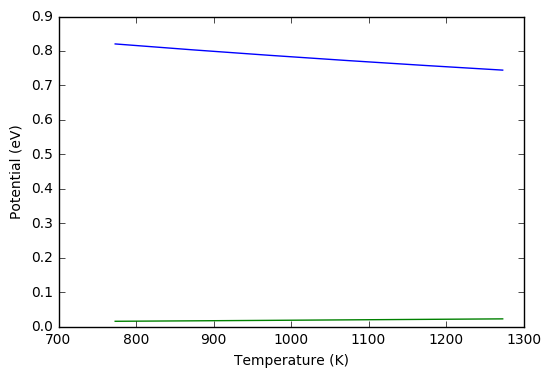

In [4]:
plt.plot( temp, space_charge_potential_list, label = '$\Phi_0^{PB}$' )
plt.plot( temp, MS_space_charge_potential, label = ' $\Phi_0^{MS}' )
plt.xlabel( 'Temperature (K)' )
plt.ylabel( 'Potential (eV)' )
plt.show()

# The Debye length and space charge width

The Poisson-Boltzmann equation can be manipulated to give the Debye length. The Debye length is the "characteristic length scale" from the Debye-Huckel equation, which is the linearised Poisson-Boltzmann equation used for dilute systems.

$$ L_D = \left( \frac{\epsilon \epsilon_0 k_BT}{2 F^2 c_{i, \infty } } \right) ^ \frac{1}{2} $$

Where $L_D$ is the Debye length, $\epsilon$ is the dielectric, $\epsilon_0$ is the vacuum permittivity, $k_B$ is the Boltzmann constant, $T$ is the temperature, $F$ is Faraday's constant and $c_{i,\infty}$ is the bulk defect density. 
$L_D$ is then used to calculate the width of the space charge region.

$$ \delta_{sc} = 2L_D \left(\frac{\Phi_0 z}   {k_BT} \right)^ \frac{1}{2}$$

Where $\Phi_0$ is the space charge potential. The space charge potential can be calculated from the Poisson-Boltzmann equation or from the Mott-Schottky model to find their respective space charge widths. 

In [5]:
SCW = np.array( [ space_charge_width( b, t, valence[0], p ) for t, p, b in zip( temp, space_charge_potential_list, bulk_density_list ) ] )
print(SCW)

[ 15.27873177  15.11835738  14.96656697  14.8224014   14.68498277
  14.55355901]
